# Data Partitioning
We need to split data into train-test partitions. Since the goal is to predict the `'K%'` for the `2024` season, we will hold out all `2024` data.
- In an attempt to limit data leakage, one true holdout set will be created by selecting players in a reserved data set that will never be used in model training.
  This will be the final evaluation data set.
- The training data will be used in a cross-validation scheme as shown below:
```  
Cross-Validation Scheme
------------------------

Data Split:
All data over all seasons split: Train & Test

Cross-Validation Steps (Train Data):
1. Train: 2021        Validate: 2022
   [2021] -> [2022]

2. Train: 2021-2022   Validate: 2023
   [2021 | 2022] -> [2023]

3. Train: 2021-2023   Validate: 2024
   [2021 | 2022 | 2023] -> [2024]

Final Evaluation:
Test Model on heldout Test data
```

In [1]:
import math

import numpy as np
import pandas as pd

from bullpen import data_utils

rng = np.random.default_rng(53)

In [2]:
data = data_utils.load_data(
    provided_path=data_utils.DATA_DIR.joinpath("k.csv"),
    supplemental_path=data_utils.DATA_DIR.joinpath("supplemental-stats.csv"),
    return_intermediaries=False,
)

data.head()

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,A.J. Minter,ATL,27,2021,221,0.257919,696,52.1,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,A.J. Minter,ATL,28,2022,271,0.346863,649,70.0,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,A.J. Minter,ATL,29,2023,260,0.315385,647,64.2,...,40,4,13,69,0.158537,8,1,0,0,0
3,621345,18655,A.J. Minter,ATL,30,2024,134,0.261194,676,34.1,...,20,1,7,28,0.200000,6,3,0,0,0
4,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463,773,66.1,...,48,6,22,54,0.289474,15,4,0,0,0


## Split players into train test buckets

In [3]:
players = data.Name.unique()

In [4]:
train_n = math.ceil(len(players) * 0.7)
test_n = len(players) - train_n
train_n, test_n

(604, 258)

In [5]:
train_idx = rng.choice(range(len(players)), size=train_n, replace=False)
test_idx = np.array([i for i in range(len(players)) if i not in train_idx])

train_players = players[train_idx]
test_players = players[test_idx]

# sniff test
set(train_players).intersection(set(test_players))

set()

In [6]:
train = data[data.Name.isin(train_players)]
train.head()

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
0,621345,18655,A.J. Minter,ATL,27,2021,221,0.257919,696,52.1,...,44,7,11,46,0.192982,11,4,0,0,0
1,621345,18655,A.J. Minter,ATL,28,2022,271,0.346863,649,70.0,...,50,2,23,71,0.244681,12,0,0,0,0
2,621345,18655,A.J. Minter,ATL,29,2023,260,0.315385,647,64.2,...,40,4,13,69,0.158537,8,1,0,0,0
3,621345,18655,A.J. Minter,ATL,30,2024,134,0.261194,676,34.1,...,20,1,7,28,0.200000,6,3,0,0,0
4,640462,19343,A.J. Puk,OAK,27,2022,281,0.270463,773,66.1,...,48,6,22,54,0.289474,15,4,0,0,0


In [7]:
train.shape

(1323, 39)

In [8]:
test = data[data.Name.isin(test_players)]
test.head()

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%,Rk,IP,...,02s,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru
23,592717,11490,Aaron Sanchez,SFG,28,2021,156,0.166667,909,35.1,...,15,2,8,18,0.307692,2,5,0,0,0
24,592717,11490,Aaron Sanchez,- - -,29,2022,265,0.154717,847,119.3,...,82,16,24,58,0.292683,12,10,0,0,0
30,670124,20132,Adam Oller,OAK,27,2022,337,0.136499,712,74.1,...,42,5,9,37,0.195652,3,6,0,0,0
31,670124,20132,Adam Oller,MIA,29,2024,189,0.190476,720,42.1,...,14,2,9,27,0.250000,5,4,0,0,0
37,425794,2233,Adam Wainwright,STL,39,2021,828,0.210145,1079,206.1,...,96,5,67,105,0.389535,30,4,0,0,0


## Quick plot to verify distributions

In [9]:
def season_dist(df):
    grouped = df.groupby("PlayerId").Season.count()
    print((grouped.value_counts() / grouped.value_counts().sum()).round(4))
    grouped.hist()

Season
1    0.3696
2    0.2572
4    0.1889
3    0.1842
Name: count, dtype: float64


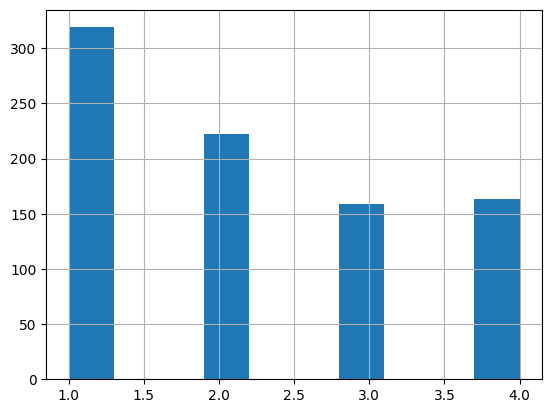

In [10]:
season_dist(data)

Season
1    0.3675
2    0.2616
4    0.1871
3    0.1838
Name: count, dtype: float64


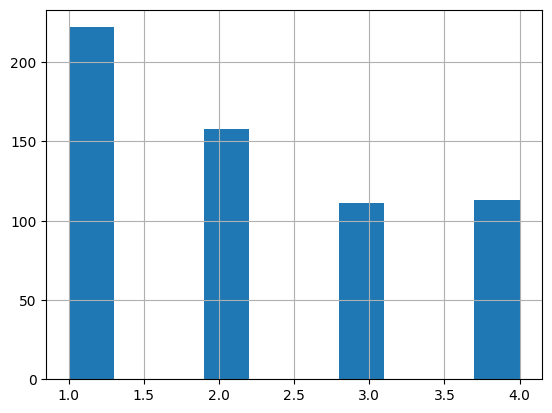

In [11]:
season_dist(train)

Season
1    0.3745
2    0.2471
4    0.1931
3    0.1853
Name: count, dtype: float64


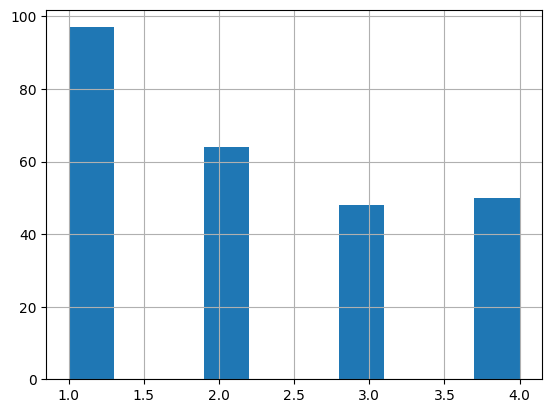

In [12]:
season_dist(test)

## Save train and test
- Train data will be used from here on until final models are ready for testing
- Test data will never be used until final evaluation

In [13]:
train.to_csv(data_utils.DATA_DIR.joinpath('train.csv'), index=False)
test.to_csv(data_utils.DATA_DIR.joinpath('test.csv'), index=False)